In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
from scipy.stats import rankdata
import pandas as pd
import glob
%matplotlib inline

In [40]:
f.close()
p.close()

In [16]:
sp = 'Mesculenta'
group = 'plants'

In [17]:
sp = 'Mtruncatula'

In [23]:
sp = 'Tcacao'

In [2]:
sp = 'papio_anubis'
group = 'animals'

In [3]:
sp = 'equus_caballus'

In [4]:
sp = 'petromyzon_marinus'

In [5]:

path = glob.glob('../../../{}/single*/{}/test_data.h5'.format(group, sp))[0]
f = h5py.File(path)

In [6]:
path = glob.glob('../../../../predictions/{}/ensemble_*/{}/predictions.h5'.format(group, sp))[0]
p = h5py.File(path)

In [4]:
f['data/X'].shape[0]

46965

In [5]:

# select examples of interest
# just look at first 10k chunks to avoid mem errors and speed things up
startenough = 0_000
enough = 10_000 + startenough

# mask to skip anything with padding
chunk_size = f['data/X'].shape[1]
print(chunk_size)
unpadded = np.sum(np.sum(f['data/X'][startenough:enough].astype(float), axis=2), axis=1) == chunk_size


20000


In [6]:
# mask to skip anything that's just big and totally ig
anynotig = np.argmax(f['data/y'][startenough:enough], axis=2) + np.argmax(p['predictions'][startenough:enough], axis=2) > 0
notig10 = np.sum(anynotig, axis=1) / chunk_size > 0.1

# percent accuracy
right = np.argmax(f['data/y'][startenough:enough], axis=2) == np.argmax(p['predictions'][startenough:enough], axis=2)
acc = np.sum(right, axis=1) / chunk_size



In [7]:
# track ori indexes
h5i = np.arange(startenough, enough, 1)

In [8]:
mask = unpadded & notig10
h5i = h5i[mask]
rankacc = rankdata(acc[mask])
rankscore = rankdata(f['scores/one_centered'][startenough:enough][mask])

In [9]:
upper = h5i.shape[0] * 0.9
lower = h5i.shape[0] * 0.1

#Low accuracy, high ref score
candidates = h5i[(rankacc < lower) & (rankscore > upper)]
#Low accuracy, low ref score
candidates = h5i[(rankacc < lower) & (rankscore < lower)]
#High accuracy, high ref score
candidates = h5i[(rankacc > upper) & (rankscore > upper)]

#High accuracy, low ref score
#candidates = h5i[(rankacc > upper) & (rankscore < lower)]
print(len(candidates))
print(candidates)

67
[  18   35   60   68   75  444  838 1153 1572 1913 2096 3033 3233 3234
 3304 3368 3378 3486 3802 4182 4356 4446 4672 4888 5334 5387 5389 5490
 5568 5718 5738 5843 6095 6261 6400 6434 6618 6632 6668 6694 7027 7083
 7105 7106 7107 7113 7160 7173 7222 7236 7237 7523 7709 7824 8155 8231
 8450 8518 8915 8951 8957 9001 9716 9738 9754 9965 9971]


In [531]:
h5i.shape

(2152,)

In [10]:
j = -1


838
b'Chromosome01' [20620000 20640000]


Text(0, 0.5, 'helixer')

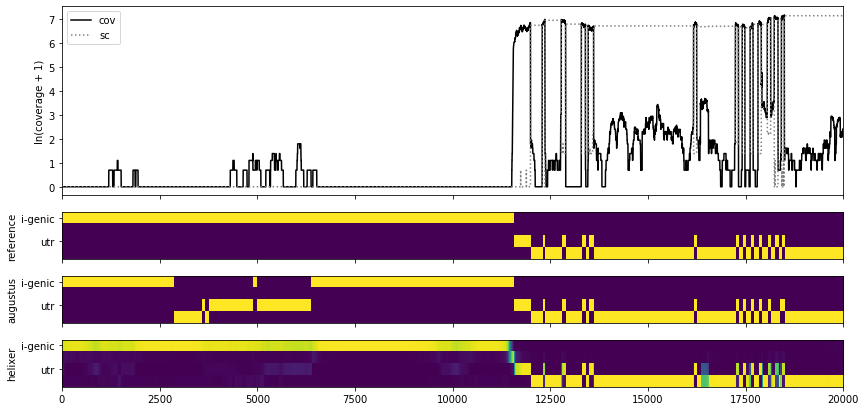

In [31]:
j += 1
i = candidates[j]
print(i)


print(f['data/seqids'][i], f['data/start_ends'][i])
fig, (ax1, ax2, axaug, ax3) = plt.subplots(4, 1, sharex=True, figsize=(14,7),
                                         gridspec_kw={"height_ratios": [2, 0.5, 0.5, 0.5]})
#plt.figure(figsize=(3,10))

ax1.plot(np.log(f['evaluation/coverage'][i] + 1), c='black')
ax1.plot(np.log(f['evaluation/spliced_coverage'][i] + 1), c='grey', linestyle=':')
ax1.set_xlim((0, chunk_size))
ax1.set_ylabel("ln(coverage + 1)")
ax1.legend(['cov', 'sc'])

yticks = ['', 'i-genic', 'utr', 'cds', 'intron']
ax2.imshow(np.array(f['data/y'][i].T).astype(float), aspect="auto")
ax2.set_yticklabels(yticks)
ax2.set_ylabel('reference')

axaug.imshow(np.array(f['alternative/augustus/y'][i].T).astype(float), aspect="auto")
axaug.set_yticklabels(yticks)
axaug.set_ylabel('augustus')

ax3.imshow(np.array(p['predictions'][i].T).astype(float), aspect="auto")
ax3.set_yticklabels(yticks)
ax3.set_ylabel('helixer')

In [8]:
def plot_selected(i, f, p, start, end, figsize=(7, 4.2), as_int=True, legend=False):
    print(i)
    print(f['data/seqids'][i], f['data/start_ends'][i])
    fig, (ax1, ax2, axaug, ax3) = plt.subplots(4, 1, sharex=True, figsize=figsize,
                                             gridspec_kw={"height_ratios": [1.2, 0.5, 0.5, 0.5]})
    #plt.figure(figsize=(3,10))

    ax1.plot(np.log(f['evaluation/coverage'][i][start:end] + 1), c='black')
    ax1.plot(np.log(f['evaluation/spliced_coverage'][i][start:end] + 1), c='dimgrey', linestyle=':')
    ax1.set_xlim((0, end - start))
    ax1.set_ylabel("ln(coverage + 1)")
    if legend:
        ax1.legend(['cov', 'sc'])

    yticks = ['IG', 'UTR', 'CDS', 'Ntrn']
    ax2.imshow(1 - np.array(f['data/y'][i][start:end].T).astype(float), aspect="auto", cmap='gray')
    ax2.set_ylim([-0.5, 3.5])
    ax2.set_yticks([0,1,2, 3])
    ax2.set_yticklabels(yticks)
    ax2.set_ylabel('Ref.')

    axaug.imshow(1 - np.array(f['alternative/augustus/y'][i][start:end].T).astype(float), aspect="auto", cmap='gray')
    axaug.set_ylim([-0.5, 3.5])
    axaug.set_yticks([0,1,2, 3])
    axaug.set_yticklabels(yticks)
    axaug.set_ylabel('Aug.')

    ax3.imshow(1 - np.array(p['predictions'][i][start:end].T).astype(float), aspect="auto", cmap='gray')
    ax3.set_ylim([-0.5, 3.5])
    ax3.set_yticks([0,1,2, 3])
    ax3.set_yticklabels(yticks)
    ax3.set_ylabel('Helixer')
    se = f['data/start_ends'][i]

    at = [x * (end - start) for x in [0, .2, .4, .60, .8, 1]]
    ax3.set_xticks(at)
    offset = f['data/start_ends'][i][0] + start
    if se[1] - se[0] > 0:
        sign = '+'
        xticklabs = [(offset + x)/ 10**3 for x in at]
    else:
        sign = '-'
        xticklabs = [(offset - x)/ 10**3 for x in at]
    if as_int:
        xticklabs = [int(x) for x in xticklabs]
    else:
        xticklabs = [round(x, 2) for x in xticklabs]
    ax3.set_xticklabels(xticklabs)
    ax3.set_xlabel('position on ({}) strand of {} in kbp'.format(sign, f['data/seqids'][i].decode()))
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


3166
b'GL476506' [500000 450000]


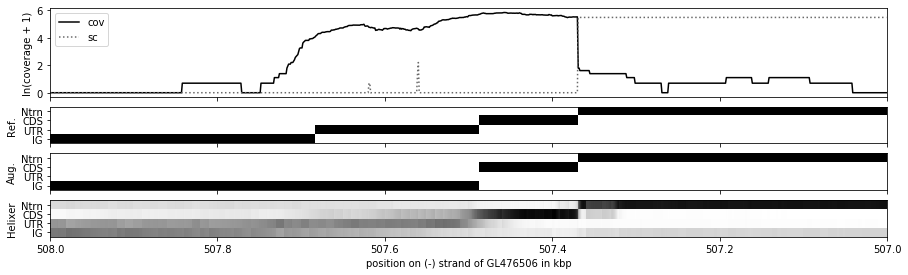

In [9]:
# petromyzon_marinus
i = 3166
start, end = 8000, 9000
plot_selected(i, f, p, start, end, figsize=(15, 4.2), as_int=False, legend=True)
plt.savefig(fname='zooms/petromyzon_marinus3166.eps')


691
b'1' [147200000 147400000]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


981
b'1' [169600000 169400000]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


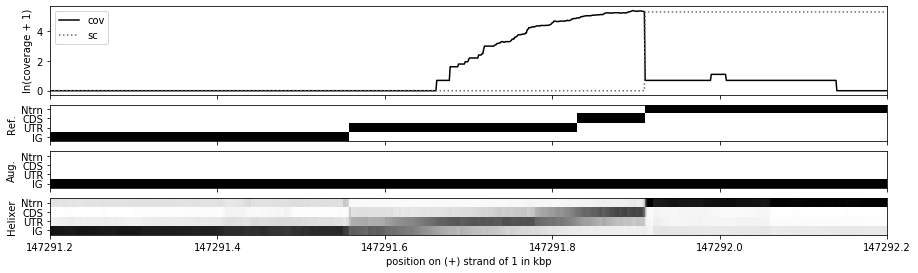

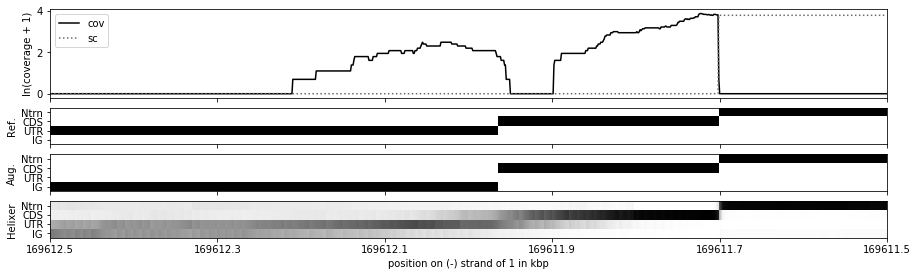

In [38]:
# equus_caballus
i = 691
start, end = 91200, 92200
plot_selected(i, f, p, start, end, figsize=(15, 4.2), as_int=False, legend=True)
plt.savefig(fname='zooms/equus_caballus691.eps')
i = 981
start, end = 12500, 13500
plot_selected(i, f, p, start, end, figsize=(15, 4.2), as_int=False, legend=True)
plt.savefig(fname='zooms/equus_caballus981.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


479
b'1' [110600000 110800000]


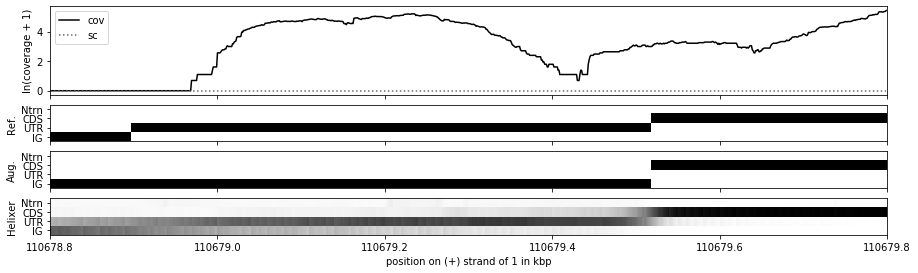

In [32]:
# papio_anubis 
i = 479
start, end = 78800, 79800
plot_selected(i, f, p, start, end, figsize=(15, 4.2), as_int=False, legend=True)

plt.savefig(fname='zooms/papio_anubis479.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


146
b'chr4' [3160000 3180000]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


1
b'chr4' [20000 40000]


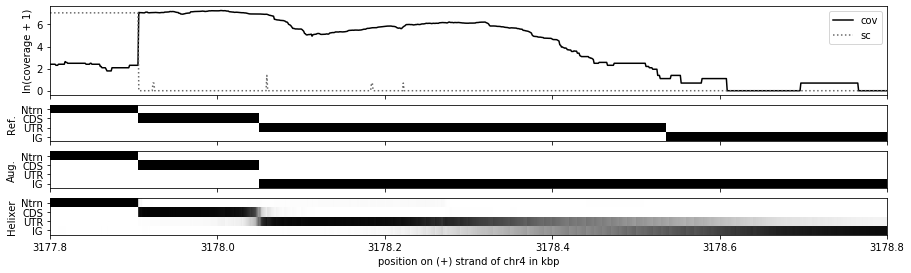

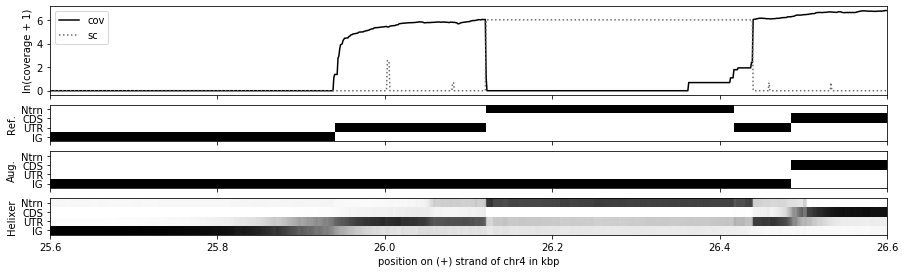

In [21]:
# Mtruncatula 
i = 146
start, end = 17800, 18800
plot_selected(i, f, p, start, end, figsize=(15, 4.2), as_int=False, legend=True)
plt.savefig(fname='zooms/Mtruncatula146.eps')
i = 1
start, end = 5600, 6600
plot_selected(i, f, p, start, end, figsize=(15, 4.2), as_int=False, legend=True)
plt.savefig(fname='zooms/Mtruncatula1.eps')

1602
b'scaffold_2' [32120000 32140000]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


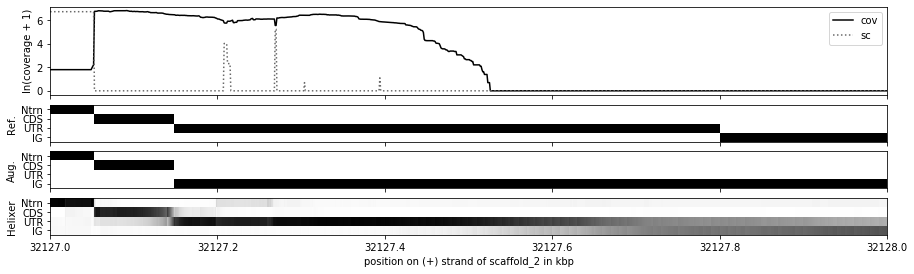

In [26]:
# Tcacao 
i = 1602
start, end = 7000, 8000
plot_selected(i, f, p, start, end, figsize=(15, 4.2), as_int=False, legend=True)
plt.savefig(fname='zooms/Tcacao1602.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


3378
b'Chromosome08' [6860000 6880000]


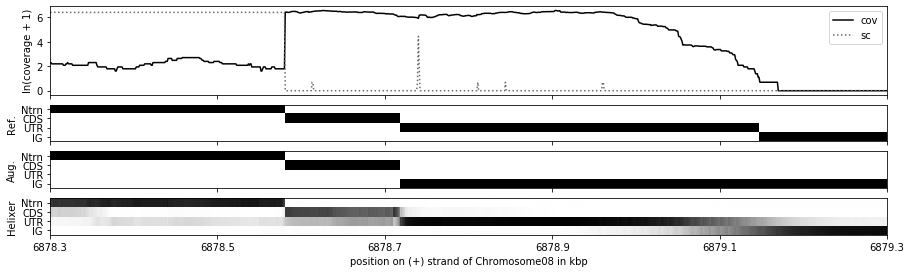

In [13]:
# Mesculenta
i = 3378
start, end = 18300, 19300
plot_selected(i, f, p, start, end, figsize=(15, 4.2), as_int=False, legend=True)
plt.savefig(fname='zooms/Mesculenta3378.eps')


6436
b'Chromosome02' [11320000 11340000]
5392
b'Chromosome08' [11360000 11340000]
1162
b'Chromosome01' [27220000 27240000]


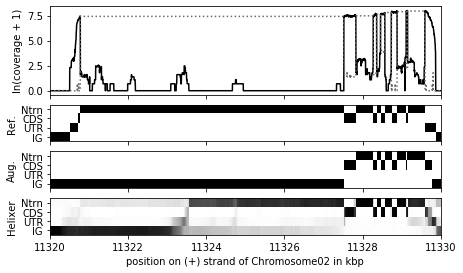

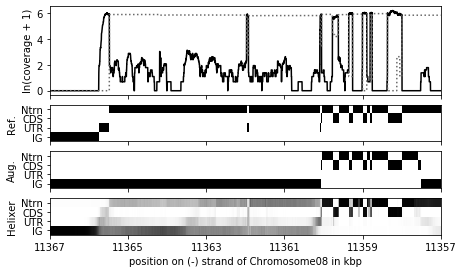

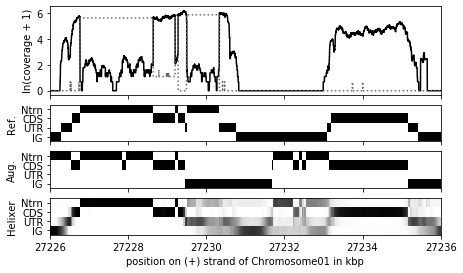

In [35]:
## Mesculenta
# high score, low acc
i = 6436
start, end = 0, 10000
plot_selected(i, f, p, start, end)
plt.savefig(fname='highScore_lowAcc_001.eps')

i = 5392
start, end = 7000, 17000
plot_selected(i, f, p, start, end)
plt.savefig(fname='highScore_lowAcc_002.eps')

i = 1162
start, end = 6000, 16000
plot_selected(i, f, p, start, end)
plt.savefig(fname='highScore_lowAcc_003.eps')

1024
b'Chromosome01' [24460000 24480000]
392
b'Chromosome01' [10540000 10560000]
432
b'Chromosome01' [11540000 11560000]


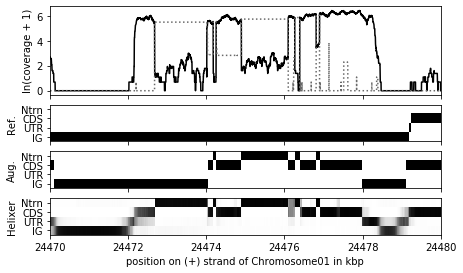

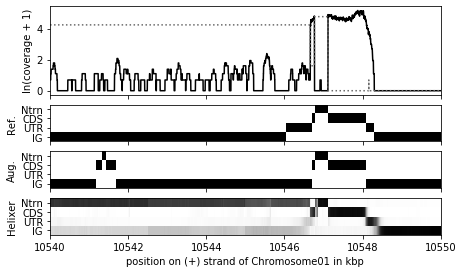

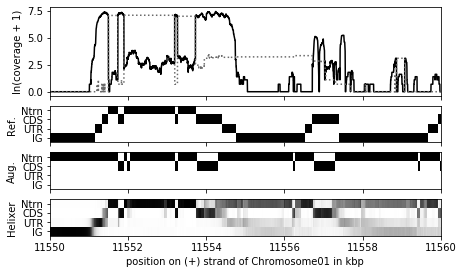

In [36]:
# low score, low acc
# looks good
i = 1024
start, end = 10000, 20000
plot_selected(i, f, p, start, end)
plt.savefig(fname='lowScore_lowAcc_001.eps')

i = 392
start, end = 0, 10000
plot_selected(i, f, p, start, end)
plt.savefig(fname='lowScore_lowAcc_002.eps')


# errors to go around
i = 432
start, end = 10000, 20000
plot_selected(i, f, p, start, end)
plt.savefig(fname='lowScore_lowAcc_003.eps')


18
b'Chromosome01' [420000 440000]
7113
b'Chromosome02' [29220000 29240000]
3233
b'Chromosome08' [3720000 3740000]


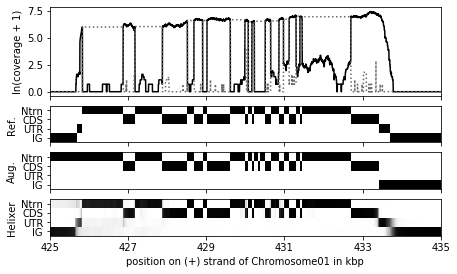

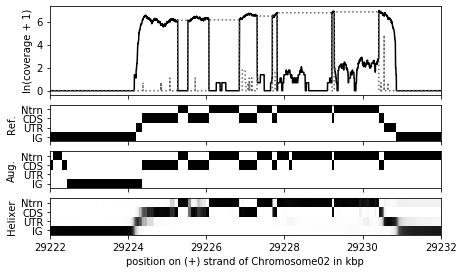

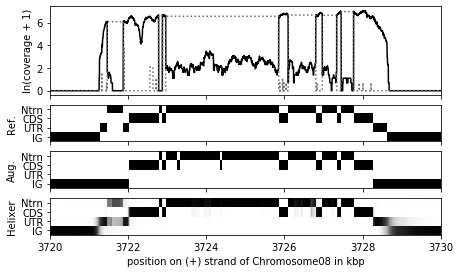

In [37]:
# high acc high score

i = 18
start, end = 5000, 15000
plot_selected(i, f, p, start, end)
plt.savefig(fname='highScore_highAcc_001.eps')


i = 7113
start, end = 2500,12500
plot_selected(i, f, p, start, end)
plt.savefig(fname='highScore_highAcc_002.eps')


i = 3233
start, end = 0, 10000
plot_selected(i, f, p, start, end)
plt.savefig(fname='highScore_highAcc_003.eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


5569
b'Chromosome08' [6940000 6920000]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


5967
b'Chromosome02' [1860000 1880000]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


9936
b'Chromosome12' [30460000 30440000]


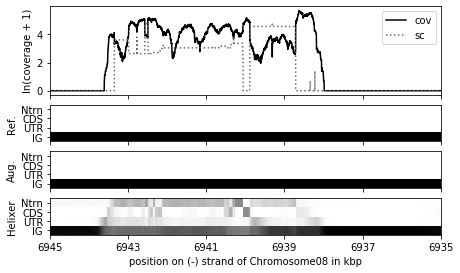

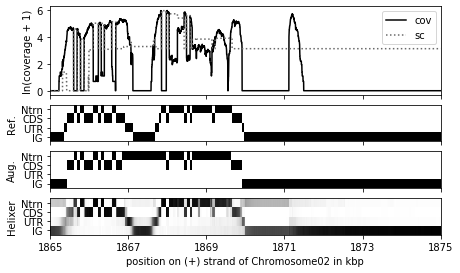

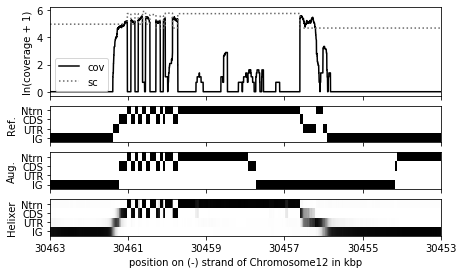

In [11]:
# high acc, low score

# ghost gene
i = 5569
start, end = 5000, 15000
plot_selected(i, f, p, start, end, legend=True)
plt.savefig(fname='lowScore_highAcc_001.eps')

# missed intron?
i = 5967
plot_selected(i, f, p, start, end, legend=True)
plt.savefig(fname='lowScore_highAcc_002.eps')

# spliced read mapping error
i = 9936
start, end = 3000, 13000
plot_selected(i, f, p, start, end, legend=True)
plt.savefig(fname='lowScore_highAcc_003.eps')
